# Jupyter Notebook  problems in the Essentials of Paleomagnetism Textbook by L. Tauxe

## Problems in Chapter 11

## Problem 1a

To do this problem, we need to call a few functions from **pmag** and **ipmag** to create the Fisher distributed set of directions and then plot them.  

In [1]:
# import PmagPy functions
import pmagpy.pmag as pmag # import the pmag module
import pmagpy.ipmag as ipmag 
import numpy as np # while we are at it, let's import numpy
# allows plotting figures in the notebook
%matplotlib inline 

Let's first use **ipmag.fishrot()** to generate a Fisher distributed set of directions and then plot it with the pair of functions **ipmag.plot_net()** and **ipmag.plot_di()**.   

In [2]:
help(ipmag.fishrot)

Help on function fishrot in module pmagpy.ipmag:

fishrot(k=20, n=100, dec=0, inc=90, di_block=True)
    Generates Fisher distributed unit vectors from a specified distribution
    using the pmag.py fshdev and dodirot functions.
    
    Parameters
    ----------
    k : kappa precision parameter (default is 20)
    n : number of vectors to determine (default is 100)
    dec : mean declination of distribution (default is 0)
    inc : mean inclination of distribution (default is 90)
    di_block : this function returns a nested list of [dec,inc,1.0] as the default
    if di_block = False it will return a list of dec and a list of inc
    
    Returns
    ---------
    di_block : a nested list of [dec,inc,1.0] (default)
    dec, inc : a list of dec and a list of inc (if di_block = False)
    
    Examples
    --------
    >>> ipmag.fishrot(k=20, n=5, dec=40, inc=60)
    [[44.766285502555775, 37.440866867657235, 1.0],
     [33.866315796883725, 64.732532250463436, 1.0],
     [47.0029127705

So we can just define the parameters and assign the output to a list

In [6]:
prob1a_data=ipmag.fishrot(k=25,n=20, dec=12,inc=45)

In [7]:
help(ipmag.plot_di)

Help on function plot_di in module pmagpy.ipmag:

plot_di(dec=None, inc=None, di_block=None, color='k', marker='o', markersize=20, legend='no', label='', title='', edge='')
    Plot declination, inclination data on an equal area plot.
    
    Before this function is called a plot needs to be initialized with code that looks
    something like:
    >fignum = 1
    >plt.figure(num=fignum,figsize=(10,10),dpi=160)
    >ipmag.plot_net(fignum)
    
    Required Parameters
    -----------
    dec : declination being plotted
    inc : inclination being plotted
    
    or
    
    di_block: a nested list of [dec,inc,1.0]
    (di_block can be provided instead of dec, inc in which case it will be used)
    
    Optional Parameters (defaults are used if not specified)
    -----------
    color : the default color is black. Other colors can be chosen (e.g. 'r')
    marker : the default marker is a circle ('o')
    markersize : default size is 20
    label : the default label is blank ('')
    leg

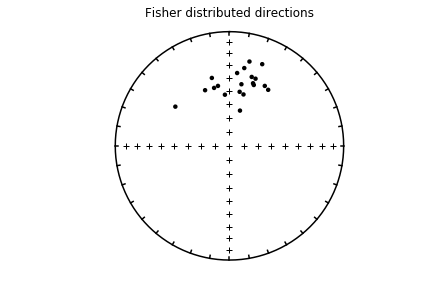

In [8]:
ipmag.plot_net(1)
ipmag.plot_di(di_block=prob1a_data,title="Fisher distributed directions")

## Problem 1b

Here we have to write a program to calcualate the Fisher statistics for the data in Problem 1a (here called prob1a_data). We can re-use some of the code we wrote in the  Chapter 2 problem sets (dir2cart and cart2dir) (which also happen to be part of the **pmag** module) and write a new function for doing the Fisher statistics.  Notice the use of a doc string (enclosed in triple quotes) at the front of the function. 

In [9]:
def fisher_mean(data):
    """
    calculates fisher statistics for data where data is an array of Dec, inc pairs.
    Returns a dictionary fpars with  dec, inc, n, R, alpha95 and CSD as keys. 
    dec and inc are the mean dec and inc for the data set. 
    """
    R = 0 # initialize R, the resultant vector length to zero
    Xbar,X=[0,0,0],[]# initialize Xbar, the container for mean x,y,z
    fpars={} # dictionary for the Fisher statistics
    N=len(data) # number of data points incoming
    if N <2: # You can't do Fisher statistics on less than 2 numbers. 
       return fpars
    # call to dir2cart transforms directions to cartesian coordinates
    X=pmag.dir2cart(data) # pmag needs to be imported before calling. 
    for i in range(len(X)):
        for c in range(3):
           Xbar[c]+=X[i][c]  # get the sum of each cartesian coordinate
    for c in range(3):
        R+=Xbar[c]**2  # get the sum of squares of the component sums.  
    R=np.sqrt(R) # take the square root
    for c in range(3):
        Xbar[c]=Xbar[c]/R  # normalize by the Resultant vector length
    dir=pmag.cart2dir(Xbar) # convert back to directions
    fpars["dec"]=dir[0]
    fpars["inc"]=dir[1]
    fpars["n"]=N
    fpars["r"]=R
    if N!=R: # if perfectly aligned kappa infinite! 
        k=(N-1.)/(N-R)
        fpars["k"]=k
        csd=81./np.sqrt(k)
    else:
        fpars['k']='inf'
        csd=0.
    b=20.**(1./(N-1.)) -1
    a=1-b*(N-R)/R
    if a<-1:a=-1
    a95=np.arccos(a)*180./np.pi
    fpars["alpha95"]=a95
    fpars["csd"]=csd
    if a<0: fpars["alpha95"] = 180.0
    return fpars


In [10]:
fpars= fisher_mean(prob1a_data)
print (fpars) # it isn't pretty, but it works.  

{'dec': 7.457529005317821, 'inc': 43.47061916238313, 'n': 20, 'r': 19.069300597577413, 'k': 20.414754700114226, 'alpha95': 7.402790860280717, 'csd': 17.92721949746367}


## Problem 1c

Here we call **ipmag.fishrot()** again.  

In [11]:
prob1c_data=ipmag.fishrot(k=25,n=20, dec=12,inc=45)
fpars2=fisher_mean(prob1c_data)
print (fpars2)

{'dec': 16.830991512248627, 'inc': 43.23446681066173, 'n': 20, 'r': 19.119814781567243, 'k': 21.586365689974976, 'alpha95': 7.189292651211202, 'csd': 17.43392823164575}


Now we can write a little function to calculate Watson's F statistic (Equation 11.16 in the Essentials textbook).  

In [12]:
def watsons_f(DI1,DI2):
    # first calculate R for the combined data set, then R1 and R2 for each individually.
    DI=np.concatenate((DI1,DI2),axis=0) # create a new array from two smaller ones
    fpars=fisher_mean(DI) # re-use our functionfrom problem 1b
    fpars1=fisher_mean(DI1)
    fpars2=fisher_mean(DI2)
    N=fpars['n']
    R=fpars['r']
    R1=fpars1['r']
    R2=fpars2['r']
    F=(N-2.)*((R1+R2-R)/(N-R1-R2))
    return F

And now we call it. 

In [13]:
print ('F = %10.5f'%watsons_f(prob1a_data,prob1c_data))

F =    1.41733


So, how do we figure out what the critical value of F is?  I found this website with F tables at:
http://www.socr.ucla.edu/Applets.dir/F_Table.html
looking at the table for $\alpha$=0.05 (95% confidence) with df$_1$=2 and  df$_2$= 2(N-2), I found the value of 3.117.  Our value above is much lower than that, so indeed these two data sets are probably drawn from the same distribution.   

Better yet,  there is a function **pmag.fcalc( )** that will also help...   

In [14]:
help(pmag.fcalc)

Help on function fcalc in module pmagpy.pmag:

fcalc(col, row)
    looks up an F-test stastic from F tables F(col,row), where row is number of degrees of freedom - this is 95% confidence (p=0.05).
    
      Parameters
      _________
          col : degrees of freedom column
          row : degrees of freedom row
    
      Returns
          F : value for 95% confidence from the F-table



In [15]:
pmag.fcalc(2,2*(fpars['n']+fpars2['n']-2))

3.117

## Problem 1d

So here all our work will pay off, because we can just re-use the functions we already wrote.  

In [17]:
prob1d_data=ipmag.fishrot(k=25,n=20, dec=55,inc=60)
print ('F = %10.5f'%(watsons_f(prob1a_data,prob1d_data))) # we already did the tranpose thing

F =   43.08511


And those two are clearly NOT drawn from the same distribution!

To check with the function **pmag.watsons_f**:

In [18]:
help(pmag.watsons_f)

Help on function watsons_f in module pmagpy.pmag:

watsons_f(DI1, DI2)
    calculates Watson's F statistic (equation 11.16 in Essentials text book).
    
    Parameters
    _________
    DI1 : nested array of [Dec,Inc] pairs
    DI2 : nested array of [Dec,Inc] pairs
    
    Returns
    _______
    F : Watson's F
    Fcrit : critical value from F table



So now we do this:

In [19]:
pmag.watsons_f(prob1a_data,prob1c_data)

(1.417329638522164, 3.117)

These are the values for F and the critical value of F for this N. The first value is way less than 3.1, so these two data sets are likely drawn from the same distribution.  

Now we re-run it with ps11_prob1d.dat and see what we get:  

In [20]:
pmag.watsons_f(prob1a_data,prob1d_data)

(43.085106586142196, 3.117)

Looks like these two are different....    
So our code is working the same way **watsons_f.py** works.  

## Problem 1e

Now we can run the function **ipmag.common_mean_watson( )**  for use within a notebok  and see how the two Watson methods compare. 


In [21]:
help(ipmag.common_mean_watson)

Help on function common_mean_watson in module pmagpy.ipmag:

common_mean_watson(Data1, Data2, NumSims=5000, print_result=True, plot='no', save=False, save_folder='.', fmt='svg')
    Conduct a Watson V test for a common mean on two directional data sets.
    
    This function calculates Watson's V statistic from input files through
    Monte Carlo simulation in order to test whether two populations of
    directional data could have been drawn from a common mean. The critical
    angle between the two sample mean directions and the corresponding
    McFadden and McElhinny (1990) classification is printed.
    
    Parameters
    ----------
    Data1 : a nested list of directional data [dec,inc] (a di_block)
    Data2 : a nested list of directional data [dec,inc] (a di_block)
    NumSims : number of Monte Carlo simulations (default is 5000)
    print_result : default is to print the test result (True)
    plot : the default is no plot ('no'). Putting 'yes' will the plot the CDF
        

Results of Watson V test: 

Watson's V:           3.5
Critical value of V:  6.3
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.3
Critical angle for M&M1990:   8.4
The McFadden and McElhinny (1990) classification for
this test is: 'B'


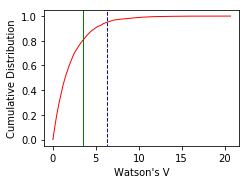

(1, 6.2501882511592033, 8.44448050102773)

In [37]:
ipmag.common_mean_watson(prob1a_data,prob1c_data,plot='yes')

Re-doing this for the other pair of files:

Results of Watson V test: 

Watson's V:           64.4
Critical value of V:  6.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 29.2
Critical angle for M&M1990:   8.9



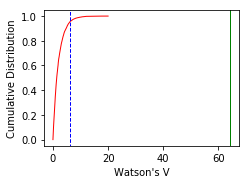

(0, 29.190965523872098, 8.8987701592550383)

In [38]:
ipmag.common_mean_watson(prob1a_data,prob1d_data,plot='yes')

So the two methods give the same answer.  

## Problem 2a

For this, we use **ipmag.fishrot()** as before.  But that returns a nested list of declination, inclination data, so to just work on the inclinations, I should turn it into an array, take the transpose (so declination is in the first row and inclination is in the second). Then I can get the inclinations out easily and calculate the average inclination value (using  the **Numpy** functions for Gaussian statistics).  

In [56]:
prob2a_data=np.array(ipmag.fishrot(k=20,n=20,inc=50)) # I'm using the same N and kappa as for the others
Incs=prob2a_data.transpose()[1] # fish out the inclinations
Incs

array([ 55.1309232 ,  63.12423536,  59.95168288,  65.29808285,
        63.28924271,  61.74565482,  49.23345375,  57.36373912,
        55.6771035 ,  55.15047068,  42.59171052,  65.97123302,
        32.28870883,  37.06095759,  53.97790742,  48.20784012,
        66.363052  ,  33.00330053,  59.07110272,  32.337026  ])

In [57]:
Incs.mean() # gaussian mean of the inclinations

52.841871381264852

## Problem 2b

For this, I can re-use **fisher_mean( )** from above.  I like this function stuff - it saves a lot of time!

In [59]:
fisher_mean(prob2a_data)

{'alpha95': 8.2323694743552718,
 'csd': 19.824226813241047,
 'dec': 1.0512241332572441,
 'inc': 56.023289973817199,
 'k': 16.694657816355814,
 'n': 20,
 'r': 18.861911384527712}

See how the Fisher mean is steeper than the gaussian mean?  

## Program 2c

I'm going to call **pmag.doincfish( )** to see if we can get a less biassed estimate for inclination.

In [60]:
help(pmag.doincfish)

Help on function doincfish in module pmagpy.pmag:

doincfish(inc)
    gets fisher mean inc from inc only data
    input: list of inclination values
    output: dictionary of
        'n' : number of inclination values supplied
        'ginc' : gaussian mean of inclinations
        'inc' : estimated Fisher mean
        'r' : estimated Fisher R value
        'k' : estimated Fisher kappa
        'alpha95' : estimated fisher alpha_95
        'csd' : estimated circular standard deviation



In [61]:
print (pmag.doincfish(Incs))

{'n': 20, 'ginc': 52.841871381264866, 'inc': 54.511871381264761, 'r': 19.210197802185128, 'k': 24.056656277441206, 'alpha95': 0.99586692010255651, 'csd': 16.514574456112801}


So that program did better at fixing the problem!

## Problem 3a

For this problem, we first need to read in the data file _ps11_prob3a.dat_  from the Chapter_11 folder and peel off the declination, inclination data.  

In [73]:
data=np.loadtxt('Chapter_11/ps11_prob3a.dat') # read in the data
import pandas as pd  # let's use this cool module for wrangling data!
df=pd.DataFrame(data,columns=['dec','inc','dip_dir','dip'])
print (df.head())

     dec   inc  dip_dir   dip
0    9.7  53.0    105.0  22.0
1  317.0  44.2    105.0  22.0
2  333.1   8.9    105.0  22.0
3  354.3  -0.1    105.0  22.0
4  338.9  50.2    105.0  22.0


And because we now know how, let's make a quickie plot.  

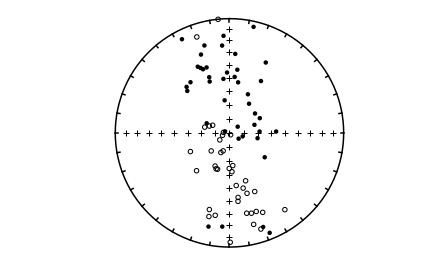

In [74]:
di_block=df[['dec','inc']].values
ipmag.plot_net(2) # make the net
ipmag.plot_di(di_block=di_block) # plot the dec,inc data

Now we can use the function **pmag.doprinc( )** to calculate the principal component of the directional data.

In [75]:
help(pmag.doprinc)

Help on function doprinc in module pmagpy.pmag:

doprinc(data)
    Gets principal components from data in form of a list of [dec,inc] data.
    
    Parameters
    ----------
    data : nested list of dec, inc directions
    
    Returns
    -------
    ppars : dictionary with the principal components
        dec : principal directiion declination
        inc : principal direction inclination
        V2dec : intermediate eigenvector declination
        V2inc : intermediate eigenvector inclination
        V3dec : minor eigenvector declination
        V3inc : minor eigenvector inclination
        tau1 : major eigenvalue
        tau2 : intermediate eigenvalue
        tau3 : minor eigenvalue
        N  : number of points
        Edir : elongation direction [dec, inc, length]



In [76]:
princ_pars=pmag.doprinc(di_block)
print (princ_pars)

{'Edir': array([ 335.70255066,  -34.70332457,    1.        ]), 'dec': 358.61577458597367, 'inc': 53.062603657226539, 'N': 80, 'tau1': 0.723094464380168, 'tau2': 0.2306561374717023, 'tau3': 0.046249398148129589, 'V2dec': 155.70255066070376, 'V2inc': 34.703324574333955, 'V3dec': 253.50393161917111, 'V3inc': 11.089856927852408}


Any vector with an angle of > 90 from the principal direction **princ_pars['dec']** and **princ_pars['inc']** belongs in the reverse polarity group.  So we can use the function **pmag.angle( )** to separate the two groups. First let's paste on the principal directions to our panda frame.

In [77]:
df['principal_dec']=princ_pars['dec'] # add the principal components to the panda frame.
df['principal_inc']=princ_pars['inc']
print (frame.head()) # I love how this works

     dec   inc  dip_dir   dip  principal_dec  principal_inc
0    9.7  53.0    105.0  22.0     358.615775      53.062604
1  317.0  44.2    105.0  22.0     358.615775      53.062604
2  333.1   8.9    105.0  22.0     358.615775      53.062604
3  354.3  -0.1    105.0  22.0     358.615775      53.062604
4  338.9  50.2    105.0  22.0     358.615775      53.062604


Let's find out what pmag.angle expects.   

In [78]:
help(pmag.angle)

Help on function angle in module pmagpy.pmag:

angle(D1, D2)
    Calculate the angle between two directions.
    
    Parameters
    ----------
    D1 : Direction 1 as an array of [declination, inclination] pair or pairs
    D2 : Direction 2 as an array of [declination, inclination] pair or pairs
    
    Returns
    -------
    angle : angle between the directions as a single-element array
    
    Examples
    --------
    >>> pmag.angle([350.0,10.0],[320.0,20.0])
    array([ 30.59060998])



So first we have to set up **D2** with the principal directions (DI1 is already set up - it is DI). Then we call **pmag.angle( )**.

In [80]:
PD=np.array([df['principal_dec'],df['principal_inc']]).transpose()
df['angle']=pmag.angle(di_block,PD)
print (df.head())

     dec   inc  dip_dir   dip  principal_dec  principal_inc      angle
0    9.7  53.0    105.0  22.0     358.615775      53.062604   6.659466
1  317.0  44.2    105.0  22.0     358.615775      53.062604  28.438617
2  333.1   8.9    105.0  22.0     358.615775      53.062604  48.741348
3  354.3  -0.1    105.0  22.0     358.615775      53.062604  53.284495
4  338.9  50.2    105.0  22.0     358.615775      53.062604  12.524863


Now all we have to do is test the angle and sort the two directions into their own frames.

In [81]:
Mode_1= df[df['angle']<=90] # these are the normal directions
Mode_2=df[df['angle']>90] # these are the reverse directions

In [84]:
Mode_2_flip=Mode_2.copy() # make a copy of Mode_2.  
Mode_2_flip['dec']=(Mode_2['dec']-180.)%360. # subtracts 180 but does modular 360 (stays 0=>360 this way.)
Mode_2_flip['inc']=-Mode_2['inc'] # take the negative of the inclination
flip_df=pd.concat([Mode_1,Mode_2_flip]) # this is the list of all the data, flipping the reverse mode.

Now we can call our old friend **fisher_mean** from Problem 1b and finish the job. 

In [85]:
DIflip=np.array([flip_df['dec'],flip_df['inc']]).transpose()
geo_stats=fisher_mean(DIflip)
# print out the statistics for the (flipped) geographic reference frame.
print ('Fisher statistics for flipped data set',geo_stats)

Fisher statistics for flipped data set {'dec': 358.94196930277531, 'inc': 51.257553593765508, 'n': 80, 'r': 66.842155995160539, 'k': 6.0040231493049898, 'alpha95': 7.0721041360252466, 'csd': 33.057030603962104}


Now we can call **pmag.dotilt_V( )**  similar to in Chapter 9, but this one works on arrays of input data.  We can the values from the pandas DataFrame **flip_frame** using the syntax **df.Series.values** where **df** is a DataFrame and **Series** is the column name.  

In [86]:
flip_data=np.array([flip_frame.dec.values,flip_frame.inc.values,flip_frame.dip_dir.values,flip_frame.dip.values]).transpose()
rot=pmag.dotilt_V(flip_data)
flip_df['dec_rot']=rot[0]
flip_df['inc_rot']=rot[1]
flip_df.head()

,dec,inc,dip_dir,dip,principal_dec,principal_inc,angle,dec_rot,inc_rot
0,9.7,53.0,105.0,22.0,358.615775,53.062604,6.659466,37.452467,49.579497
1,317.0,44.2,105.0,22.0,358.615775,53.062604,28.438617,336.467520,60.944720
2,333.1,8.9,105.0,22.0,358.615775,53.062604,48.741348,338.016562,22.992294
3,354.3,-0.1,105.0,22.0,358.615775,53.062604,53.284495,355.656248,7.515567
4,338.9,50.2,105.0,22.0,358.615775,53.062604,12.524863,8.176957,58.607949


Repeat **fisher_mean( )** call with tilt corrected data: 

In [87]:
DItilt=np.array([flip_df['dec_rot'],flip_df['inc_rot']]).transpose()
tilt_stats=fisher_mean(DItilt)
print ('Fisher statistics for Mode 1',tilt_stats)

Fisher statistics for Mode 1 {'dec': 359.13686781062501, 'inc': 36.082941162612741, 'n': 80, 'r': 73.932311919916472, 'k': 13.019785947683799, 'alpha95': 4.5647302763823205, 'csd': 22.448281345346874}


To finish this off, we take the ratio of the two k values (before and after tilt) and compare with the F-table values ($\alpha$=.05 and degrees of freedom 2(N1-1) and 2(N2-1).   Now you should know that there is also a pmag.fcalc()

In [88]:
print (geo_stats['k']/tilt_stats['k'])

0.461146072096


In [89]:
print (pmag.fcalc(2*geo_stats['n']-1,2*tilt_stats['n']))

1.6366


So our F value would pass the McElhinny fold test.